## Libraries Import

In [47]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from torchvision import models


from sklearn.model_selection import train_test_split

import cv2
import os

import imgaug.augmenters as iaa
from PIL import Image
import numpy as np

import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

DEFINE VARIABLES HERE

In [49]:
ANNOTATION_FILE_PATH = "../../annotations.csv"
IMAGE_DIR = 'images'
VALIDATION_RATIO = 0.1
RANDOM_STATE = 42
BATCH_SIZE = 32
LEARNING_RATE = 1e-6
WEIGHT_DECAY = 1e-4
EPOCHS = 20

### We first explore the data given in the annotations file

In [3]:
df = pd.read_csv(ANNOTATION_FILE_PATH)


In [4]:
df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


In [5]:
df = df.sample(frac = 1)

### Checking the ratio of train vs test data

In [6]:
print(df['Partition'].value_counts())

Partition
train    2175
test      977
Name: count, dtype: int64


Text(0, 0.5, 'Count')

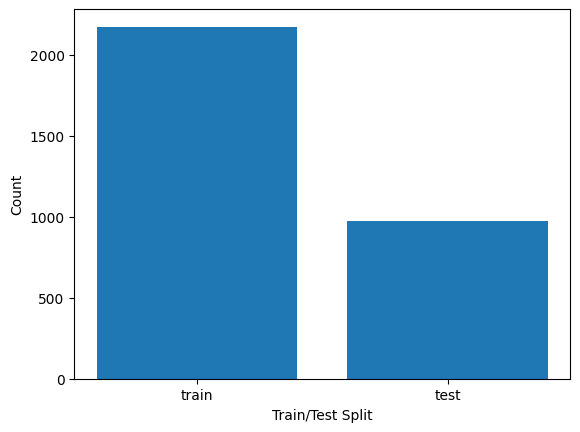

In [50]:
plt.bar( ['train', 'test'],df['Partition'].value_counts())
plt.xlabel('Train/Test Split')
plt.ylabel('Count')

### Let's check the distribution of the classes "SSA" and "HP"

In [7]:
train_ssa_count = len(df[(df['Partition'] == 'train') & (df['Majority Vote Label'] == 'SSA')])
train_hp_count = len(df[(df['Partition'] == 'train') & (df['Majority Vote Label'] == 'HP')])

print(f"[INFO]: \n SSA Images in train Dataset: {train_ssa_count}\n HP Images in train Dataset: {train_hp_count}")

[INFO]: 
 SSA Images in train Dataset: 630
 HP Images in train Dataset: 1545


Text(0, 0.5, 'Count')

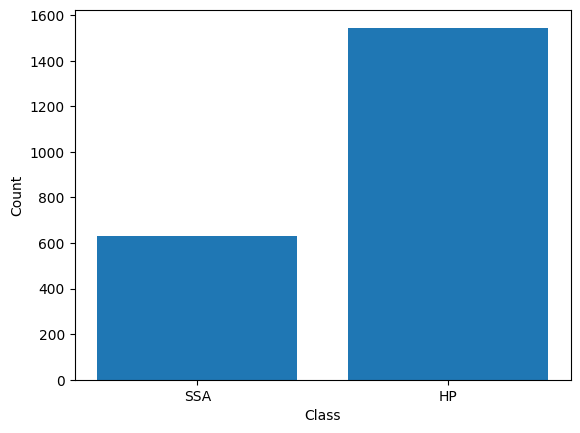

In [8]:
plt.bar(['SSA', 'HP'], [train_ssa_count, train_hp_count])
plt.xlabel('Class')
plt.ylabel('Count')

### The class distribution is imbalanced, to deal with this, we can employ 3 approaches:

1. Augment the dataset for "SSA" class <br> 2. Down-Sample the "HP" class <br> 3. Check the number of voters for each class and only pick the data point if majority of voters vote for that class 

In [9]:
print(df['Number of Annotators who Selected SSA (Out of 7)'].value_counts())

Number of Annotators who Selected SSA (Out of 7)
0    723
1    705
2    426
7    356
3    308
6    250
4    216
5    168
Name: count, dtype: int64


#### This Bar Plot shows the correlation between the number of voters for SSA class, as evident, the 75 percentile of the data lies in the first half, i.e against SSA

<BarContainer object of 8 artists>

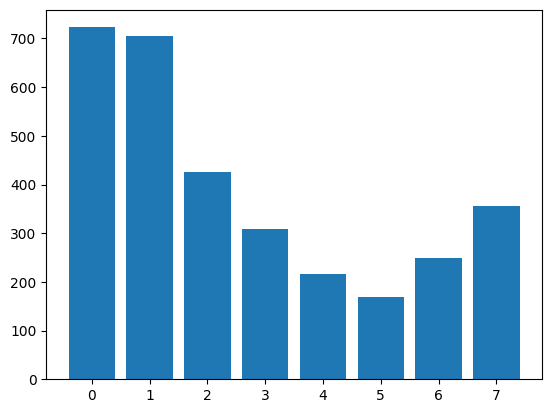

In [51]:
plt.bar( [0, 1, 2, 7, 3, 6, 4, 5],df['Number of Annotators who Selected SSA (Out of 7)'].value_counts())

The number "308" suggests that there are atleast 308 completely ambigious points of data¶

In [10]:
df[df['Number of Annotators who Selected SSA (Out of 7)'] == 3]['Majority Vote Label'].value_counts()

Majority Vote Label
HP    308
Name: count, dtype: int64

### Now we check, how many data points have almost complete confidence i.e if the number of voters for SSA is < 1 that means we are confident that this image belongs to HP class

In [11]:
high_confidence_hp = df[df['Number of Annotators who Selected SSA (Out of 7)'] < 1]['Majority Vote Label'].value_counts()
print(high_confidence_hp)

Majority Vote Label
HP    723
Name: count, dtype: int64


### On the other hand, how many data points have almost complete confidence i.e if the number of voters for SSA is >= 6 that means we are confident that this image belongs to SSA class

In [12]:
high_confidence_ssa = df[df['Number of Annotators who Selected SSA (Out of 7)'] >= 6]['Majority Vote Label'].value_counts()
print(high_confidence_ssa)

Majority Vote Label
SSA    606
Name: count, dtype: int64


##### To keep our training data clean to train the model, we keep only these datapoints as mentioned in the two cells above

In [13]:
df_updated = df[(df['Number of Annotators who Selected SSA (Out of 7)'] >= 6) | (df['Number of Annotators who Selected SSA (Out of 7)'] < 1)]

In [14]:
df_updated.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
1915,MHIST_dsj.png,HP,0,train
2905,MHIST_cze.png,SSA,7,test
3056,MHIST_dxs.png,SSA,7,train
862,MHIST_brp.png,HP,0,test
2189,MHIST_egl.png,HP,0,train


##### Now, since we removed much datapoints, we now visualize the distribution of classes in this high confidence dataset

Text(0, 0.5, 'Count')

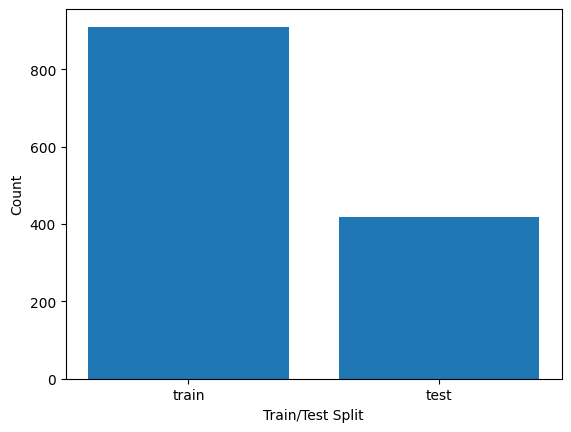

In [15]:
plt.bar( ['train', 'test'],df_updated['Partition'].value_counts())
plt.xlabel('Train/Test Split')
plt.ylabel('Count')

In [16]:
train_ssa_count = len(df_updated[(df_updated['Partition'] == 'train') & (df_updated['Majority Vote Label'] == 'SSA')])
train_hp_count = len(df_updated[(df_updated['Partition'] == 'train') & (df_updated['Majority Vote Label'] == 'HP')])

print(f"[INFO]: \n SSA Images in train Dataset: {train_ssa_count}\n HP Images in train Dataset: {train_hp_count}")

[INFO]: 
 SSA Images in train Dataset: 373
 HP Images in train Dataset: 537


#### As evident, the ratio of SSA class vs HP class has improved from 1:2 to 4:5

Text(0, 0.5, 'Count')

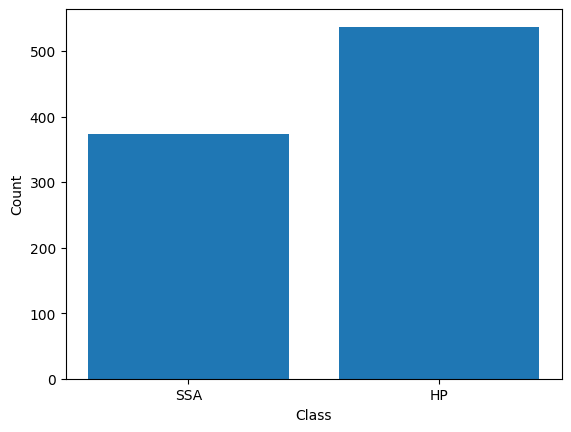

In [17]:
plt.bar(['SSA', 'HP'], [train_ssa_count, train_hp_count])
plt.xlabel('Class')
plt.ylabel('Count')

In [18]:
train_df = df_updated[df_updated['Partition'] == 'train']
test_df = df[df['Partition'] == 'test']

In [19]:
# train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state= 42)

In [20]:
pre_aug_df = train_df.copy()

In [21]:
pre_aug_df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
1915,MHIST_dsj.png,HP,0,train
3056,MHIST_dxs.png,SSA,7,train
2189,MHIST_egl.png,HP,0,train
2807,MHIST_ehc.png,SSA,7,train
699,MHIST_bjf.png,HP,0,train


<BarContainer object of 2 artists>

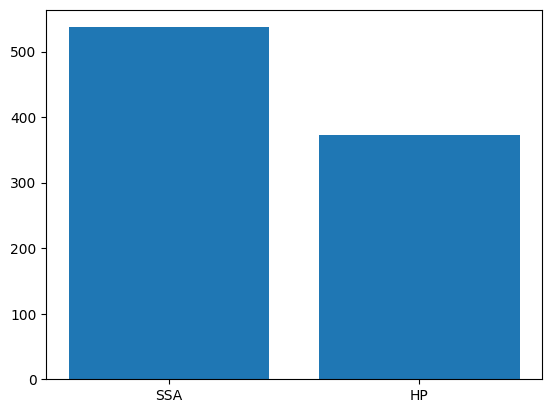

In [22]:
plt.bar(['SSA', 'HP'], pre_aug_df['Majority Vote Label'].value_counts())

#### Data Augmentation Block

In [23]:
image_name = []
label = []
num_voters = []
partition = []

## Use this function to horizontally flip the image and save
def horizontalAugment(image_path, output_path):
  image = Image.open(image_path)
  image_array = np.array(image)

  # Define augmentation pipeline
  augmentation = iaa.Sequential([
      iaa.Fliplr(1.0),        # Horizontal flip
      iaa.GaussianBlur(sigma=(0, 1.0)),  # Gaussian blur
      iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Gaussian noise
  ])

  # Apply augmentation to the image
  augmented_image_array = augmentation(image=image_array)

  # Convert augmented array back to image
  augmented_image = Image.fromarray(augmented_image_array.astype('uint8'))

  augmented_image.save(output_path)


## Use this function to vertically flip the image and save
def verticalAugment(image_path, output_path):
  image = Image.open(image_path)
  image_array = np.array(image)

  # Define augmentation pipeline
  augmentation = iaa.Sequential([
      iaa.Flipud(1.0),        # Horizontal flip
      iaa.GaussianBlur(sigma=(0, 1.0)),  # Gaussian blur
      iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Gaussian noise
  ])

  # Apply augmentation to the image
  augmented_image_array = augmentation(image=image_array)

  # Convert augmented array back to image
  augmented_image = Image.fromarray(augmented_image_array.astype('uint8'))

  augmented_image.save(output_path)



for i in tqdm(range(len(pre_aug_df))):
    img_path = os.path.join("images_orig", pre_aug_df['Image Name'].iloc[i])
    output_folder_path="images_orig"
    
    ha_path = os.path.join(output_folder_path, pre_aug_df['Image Name'].iloc[i][:-4] + "hflip.png")
    va_path = os.path.join(output_folder_path, pre_aug_df['Image Name'].iloc[i][:-4] + "vflip.png")
    
    horizontalAugment(img_path, ha_path)
    verticalAugment(img_path, va_path)
    
    image_name.append(pre_aug_df['Image Name'].iloc[i][:-4] + "hflip.png")
    image_name.append(pre_aug_df['Image Name'].iloc[i][:-4] + "vflip.png")

    if(pre_aug_df['Majority Vote Label'].iloc[i] == 'SSA'):
        label.append("SSA")
        label.append("SSA")
    else:
        label.append('HP')
        label.append('HP')
    
    num_voters.append(pre_aug_df['Number of Annotators who Selected SSA (Out of 7)'].iloc[i])
    num_voters.append(pre_aug_df['Number of Annotators who Selected SSA (Out of 7)'].iloc[i])
    
    partition.append('train')
    partition.append('train')


new_df = pd.DataFrame({'Image Name': image_name, 'Majority Vote Label': label, 'Number of Annotators who Selected SSA (Out of 7)': num_voters, 'Partition':partition})
final_df = pd.concat([df_updated, new_df], axis = 0)
final_df.to_csv("augmented_only_high_confidence.csv",index = False)

100%|████████████████████████████████████████████████████████████████████████████████| 910/910 [00:32<00:00, 27.85it/s]


## Let's look at the Augmented Data

In [24]:
augmented_df = pd.read_csv("augmented_only_high_confidence.csv")

In [25]:
augmented_df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_dsj.png,HP,0,train
1,MHIST_cze.png,SSA,7,test
2,MHIST_dxs.png,SSA,7,train
3,MHIST_brp.png,HP,0,test
4,MHIST_egl.png,HP,0,train


### The SSA vs HP class distribution is improved!

<BarContainer object of 2 artists>

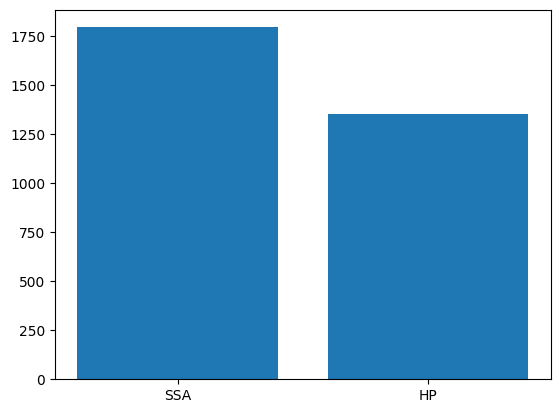

In [26]:
plt.bar(['SSA', 'HP'], augmented_df['Majority Vote Label'].value_counts())

In [27]:
train_df = augmented_df[augmented_df['Partition'] == 'train']
test_df = df[df['Partition'] == 'test']

In [28]:
train_df, val_df = train_test_split(train_df, test_size = 0.1, random_state= 42)

### Data Pipeline starts

##### Step 1. We first create a Custom Dataset class, that takes the updated dataframe object, image folder and transforms ( optional)

In [29]:
class MHIST_Dataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = torch.tensor(image, dtype=torch.float32)

        if self.img_labels.iloc[idx, 1] == 'SSA':
          label = 0
        else:
          label = 1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Step 4: Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



train_dataset = MHIST_Dataset(dataframe=train_df, img_dir='images_orig'  )
val_dataset = MHIST_Dataset(dataframe=val_df, img_dir='images_orig' )

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

##### Step2. Let's verify the data and check the shape before feeding it into the pipeline, each data point here is of the form [# number of points in batch, number of channels, width, height]

In [30]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Train Feature batch shape: {train_features.size()}")
print(f"Train Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

C:\Users\deepa\AppData\Local\Temp\ipykernel_15640\3975757280.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Train Feature batch shape: torch.Size([32, 3, 224, 224])
Train Labels batch shape: torch.Size([32])


In [31]:
val_features, val_labels = next(iter(val_dataloader))
print(f"Test Feature batch shape: {val_features.size()}")
print(f"Test Labels batch shape: {val_labels.size()}")

C:\Users\deepa\AppData\Local\Temp\ipykernel_15640\3975757280.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Test Feature batch shape: torch.Size([32, 3, 224, 224])
Test Labels batch shape: torch.Size([32])


##### Step3: Check whether there is a GPU available for training! Also load the model for TRANSFER LEARNING

In [32]:
device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")

torch.manual_seed(42)
model = models.resnet18(pretrained=True)
# Modify the classifier (fc) according to your specific requirements
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output units for binary classification

model.to(device)

Training on GPU


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##### Step4: Setting the Loss function, since this is a classification task, we use CrossEntropyLoss i.e log loss

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6, weight_decay=1e-4)
best_val_accuracy = 0.0

#### We are using checkpoints to save the best model, based on validation accuracy

In [34]:
# Model checkpointing
checkpoint_path = 'models/resnet18_1e-6_batch_SIZE_32_AUGMENTED_Epoch5_Adam.pth'


epochs = 5

train_losses = []
val_losses = []


train_correct = []
val_correct = []

In [35]:


for i in range(epochs):

  trn_corr = 0
  vl_corr = 0

  model.train()
  for b, (X_train, y_train) in tqdm(enumerate(train_dataloader)):

    X_train, y_train  = X_train.to(device), y_train.to(device)
    #predict
    optimizer.zero_grad()
    y_pred = model(X_train)
    # calculate cross entropy loss
    #print(y_pred.shape)
    #print(y_pred.device, y_train.device)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()

    trn_corr += batch_corr



    loss.backward()
    optimizer.step()

    if (b+1)%10 ==0:
      print(f"[INFO]: Epoch: {i} Batch: {b+1} Training Loss: {loss.item()}")

  train_losses.append(loss.item())
  train_correct.append(trn_corr)



  ## Testing
  with torch.no_grad():
    correct, total = 0, 0
    for b, (X_val, y_val) in enumerate(val_dataloader):
      X_val, y_val = X_val.to(device), y_val.to(device)
      y_val_pred = model(X_val)

      total += y_val.size(0)
      #correct += (y_val_pred.data == y_val).sum().item()

      predicted = torch.max(y_val_pred.data, 1)[1]
      correct += (predicted == y_val).sum()
      vl_corr += (predicted == y_val).sum()

      loss = criterion(y_val_pred, y_val)
      val_losses.append(loss.item())
      val_correct.append(vl_corr)

    val_accuracy = correct / total
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(model.state_dict(), checkpoint_path)



0it [00:00, ?it/s]C:\Users\deepa\AppData\Local\Temp\ipykernel_15640\3975757280.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
77it [00:39,  1.93it/s]
77it [00:39,  1.97it/s]
77it [00:40,  1.90it/s]
77it [00:41,  1.86it/s]
77it [00:41,  1.84it/s]


### As seen the model has a continious decreasing loss and validation loss is decreasing as well

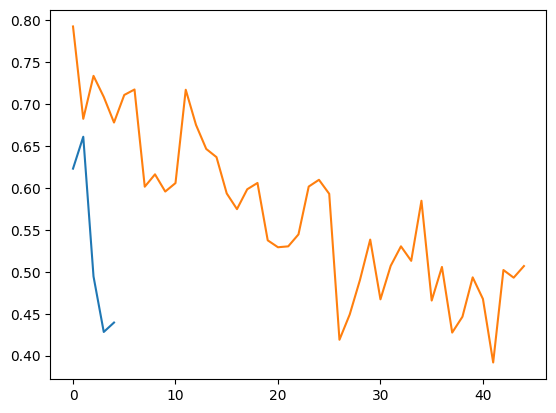

In [36]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### Testing Phase

In [37]:
test_dataset = MHIST_Dataset(dataframe=test_df, img_dir='images_orig')

In [38]:
model_path = checkpoint_path
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [39]:
model.eval()

preds = []
original = []

with torch.no_grad():

  for i in tqdm(range(len(test_dataset))):
    pred = model(test_dataset[i][0].view(1, 3, 224, 224).to(device))
    preds.append(pred.argmax().item())
    original.append(test_dataset[i][1])

  0%|                                                                                          | 0/977 [00:00<?, ?it/s]C:\Users\deepa\AppData\Local\Temp\ipykernel_15640\3975757280.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
100%|████████████████████████████████████████████████████████████████████████████████| 977/977 [00:24<00:00, 39.87it/s]


### Now we use accuracy, precision, recall and F1 to check how we did on the unseen testing data

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, auc

print(f"[INFO]: \nAccuracy: {accuracy_score(original, preds)} \nPrecision: {precision_score(original, preds)} \nRecall: {recall_score(original, preds)} \nF1: {f1_score(original, preds)} \n " )
print(confusion_matrix(original, preds))

[INFO]: 
Accuracy: 0.6888433981576254 
Precision: 0.7903525046382189 
Recall: 0.6904376012965965 
F1: 0.7370242214532872 
 
[[247 113]
 [191 426]]


### Grad-Cam implementation to visualize heat map

In [41]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import cv2
import numpy as np

In [42]:
target_layers = [model.layer4[-1]]

In [43]:
cam = GradCAM(model=model, target_layers=target_layers)


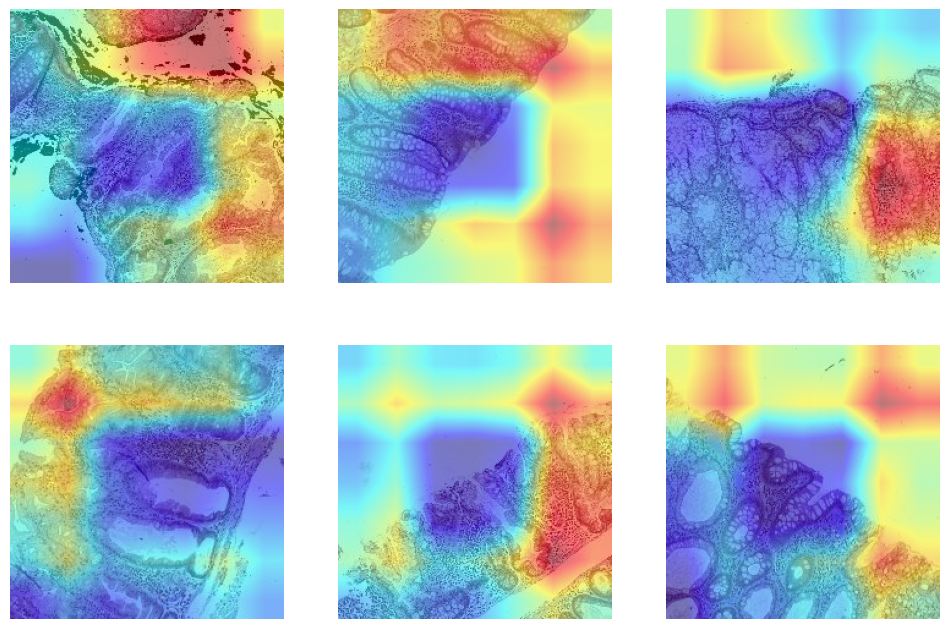

In [44]:
import random
test_df = test_df.sample(frac = 1)

vizs = []
num_subplots_per_row = 3
for idx in range(6):    
    rgb_img = cv2.imread(os.path.join('images', test_df['Image Name'].iloc[idx]),)
    input_tensor = torch.tensor(rgb_img, dtype=torch.float32).view(1, 3, 224, 224).to(device)
    
    # input_tensor = test_dataset[idx][0].view(1, 3, 224, 224).to(device)
    
    targets = [ClassifierOutputTarget(1)]
    
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    
    # In this example grayscale_cam has only one image in the batch:
    
    
    # rgb_img = rgb_img.detach().numpy()
    rgb_img = rgb_img.astype(np.float32)
    rgb_img /= 255.0
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # You can also get the model outputs without having to re-inference
    model_outputs = cam.outputs
    vizs.append(visualization)
    
    # cv2.imshow("vis", visualization)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
num_images = len(vizs)
num_rows = (num_images + num_subplots_per_row - 1) // num_subplots_per_row

fig, axes = plt.subplots(num_rows, num_subplots_per_row, figsize=(12, 8))

for i in range(num_images):
    ax = axes[i // num_subplots_per_row, i % num_subplots_per_row]
    ax.imshow(vizs[i])
    ax.axis('off')

plt.show()